# `autograd` Demo

### “Lightweight Autograd Engine with Visualized Computation Graph and Automatic Backpropagation”

---

### 🧩 Contents
1. **Computation Graph Visualization**  
   - Shape-aware visualized DAG for arbitrary models showing relationships of `Tensor` and `Function` nodes.
2. **Training Benchmark**  
   - CPU backend benchmark vs. `PyTorch` showing correctness (accuracy ~0.96) and lower runtime overhead.

    Note: This benchmark uses small tensor workloads (≤64×64), where framework-level overhead becomes the dominant factor.\
    The result demonstrates the lightweight design efficiency of the custom C++ autograd engine:

#### 📈 Benchmark Results Summary
| Model | #Params | Accuracy | Forward total | Backward total | Speedup |
|--------|----------|-----------|-----------|------------|------------|
| PyTorch (Single-thread) | 4,736 | 0.95-0.96 | 3.82s | 10.41s | – |
| `autograd` (C++) | 4,736 | 0.95-0.96 | **3.31s** | **8.00s** | **1.2-1.3x** |

Note: Under PyTorch’s default multi-threaded mode, \
total runtime increased to **12.07s (forward)** and **32.49s (backward)** due to threading overhead on small tensor workloads.

---

---
# 1. Computation Graph Visualization

In [1]:
# import autograd and autograd ops

import autograd as myautograd__
from autograd import Autograd as MyAutograd__, AutogradBackends, Tensor
from autograd import Functional as F  # All operations are now integrated in 'autograd.Functional'

#### 1-1 Importing `autograd`

In [2]:
# Setting autograd engine's backend as C++ (Py backend is only for prototyping)

MyAutograd__.set_backend(AutogradBackends.C)
MyAutograd__.set_track_graph(True)

#### 1-2 Drawing computation graphs & backward for arbitrary networks

- 1-2-1 Simple graph with residual connections and tensor reuses

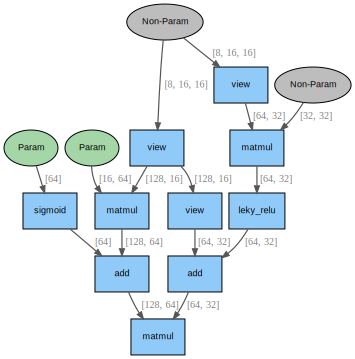

-------- Backward result ---------
Gradient of x: None
Gradient of a: Tensor(shape=[16, 64], data=[0.0333677, -0.0556885, -0.104847, 0.0294909, -0.0244922, 0.0117031, 0.0569553, 0.052659, -0.00640276, -0.155702...])


In [3]:
# MyAutograd__.reset()

x = myautograd__.randn([8, 16, 16], 0.1)  # non-param
p1 = myautograd__.randn([16, 64], 0.1)  # params
p1_ = myautograd__.randn([64], 0.1)  # bias params
np2 = myautograd__.randn([32, 32], 0.1)  # non-param

p1.requires_grad = True
p1_.requires_grad = True


# computation graph
p1_ = F.sigmoid.forward([p1_])
x1 = F.view.forward([x], [128, 16])
x_res = F.view.forward([x1], [64, 32])
x1 = F.mm.forward([x1, p1])
x1 = F.add.forward([x1, p1_])
x2 = F.view.forward([x], [64, 32])
x2 = F.mm.forward([x2, np2])
x2 = F.relu.forward([x2])
x2_ = F.add.forward([x_res, x2])
x3 = F.mm.forward([x1, x2_])


display(MyAutograd__.draw_computation_graph())

init_grad = myautograd__.randn([128, 32], 0.1)

# Performing Backward
x3.backward(init_grad)  # supports initial incoming gradients

print("-------- Backward result ---------")
print("Gradient of x:", x.grad)
print("Gradient of a:", p1.grad)

- 1-2-2 Complex graph involving multiple layered parameter reuses

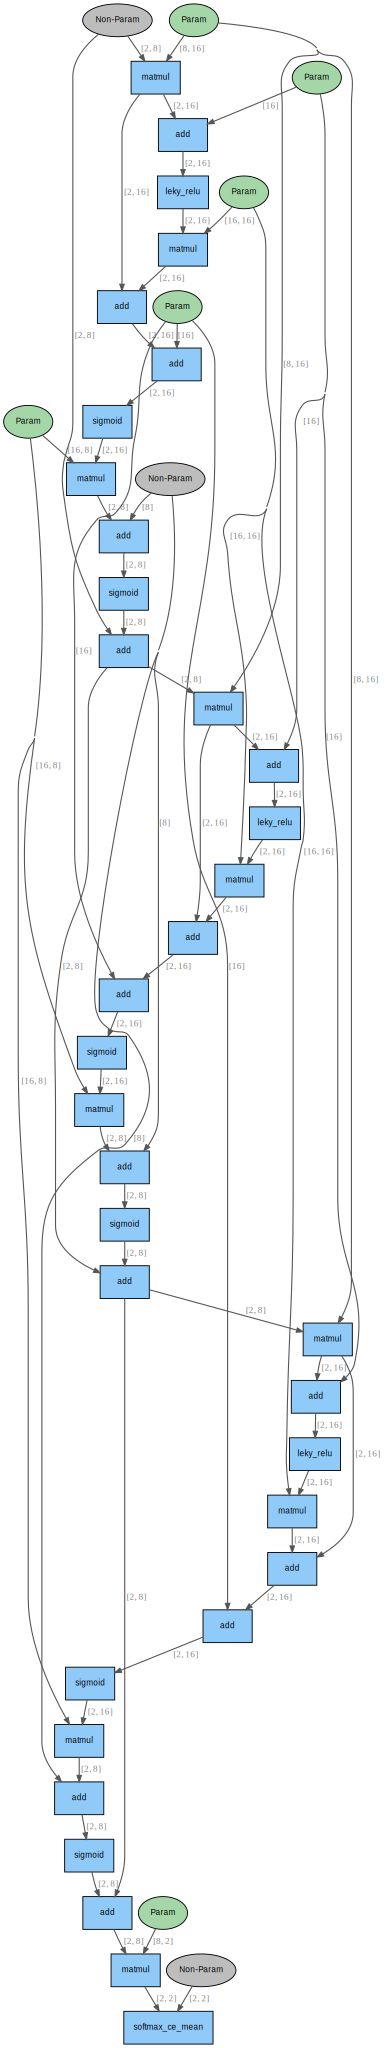

-------- Backward result ---------
Gradient of a:  Tensor(shape=[8, 16], data=[-0.220997, -0.418395, -0.490981, -0.0987312, 0.535315, 0.223951, 0.00190973, -0.00294784, -0.00810876, 0.000497847...])
Gradient of a_:  Tensor(shape=[16], data=[-0.139766, -0.21244, -0.268687, 0.045373, 0.0865646, 0.119897, 0.000889181, -0.00173122, 0.0013897, 0.000471959...])
Gradient of b:  Tensor(shape=[16, 16], data=[-4.79284e-07, 0.000594187, -0.00450412, -0.0743962, 0.194008, 2.40596e-06, 0.000690699, 1.01846e-06, -0.00144451, -0.000371973...])
Gradient of b_:  Tensor(shape=[16], data=[-5.29055e-06, 0.00130962, -0.00848935, -0.0918523, 0.207624, 2.35406e-06, 0.000391829, 6.90726e-07, -0.00549855, -0.000196276...])
Gradient of c:  Tensor(shape=[16, 8], data=[0.7531, 0.314086, -0.0121071, -0.00698908, -0.188203, 0.431115, -0.0988656, 0.00404636, 0.752405, 0.313759...])
Gradient of d:  Tensor(shape=[8, 2], data=[-1.36962, 1.36962, -0.0764344, 0.0764344, 1.11237, -1.11237, -0.506862, 0.506862, -0.768057, 

In [ ]:
MyAutograd__._graph.clear()

x = myautograd__.randn([2, 8], 1.0)

a = myautograd__.randn([8, 16], 1.0)
a_ = myautograd__.randn([16], 1.0)
b = myautograd__.randn([16, 16], 1.0)
b_ = myautograd__.randn([16], 1.0)
c = myautograd__.randn([16, 8], 1.0)
c_ = myautograd__.randn([8], 1.0)  # non-param
d = myautograd__.randn([8, 2], 1.0)

import numpy as np
y = myautograd__.from_numpy(np.array([[1.0, 0.0], [0.0, 1.0]]))  # target

a.requires_grad = True  # params
a_.requires_grad = True
b.requires_grad = True
b_.requires_grad = True
c.requires_grad = True
d.requires_grad = True

def layer(x):
    x_res = F.mm.forward([x, a])
    x = F.add.forward([x_res, a_])         # residual connection
    x = F.relu.forward([x])

    x = F.mm.forward([x, b])
    x = F.add.forward([x, x_res])          # residual connection
    x = F.add.forward([x, b_])
    x = F.sigmoid.forward([x])

    x = F.mm.forward([x, c])
    x = F.add.forward([x, c_])
    x = F.sigmoid.forward([x])
    return x

for i in range(3):  # involves multiple parameter reuse (which is not common)
    x_ = layer(x)
    x = F.add.forward([x, x_])          # residual connection

x = F.mm.forward([x, d])                # readout
x = F.softmax_ce_mean.forward([x, y])   # loss

display(MyAutograd__.draw_computation_graph())


# Backward test
x.backward()  # when no args given, should be scalar

print("-------- Backward result ---------")
print("Gradient of a: ", a.grad)
print("Gradient of a_: ", a_.grad)
print("Gradient of b: ", b.grad)
print("Gradient of b_: ", b_.grad)
print("Gradient of c: ", c.grad)
print("Gradient of d: ", d.grad)

---
# 2. Training benchmark versus `PyTorch`

#### 2-1 Preparing Training Data

<span style="color: red;">[* NOTE]</span> **The benchmark is done under both single-threaded environment**,
since PyTorch rather suffers significant bottlenecks under multi-threading while executing small-sized model's training.

Class 0: 128 samples
Class 1: 342 samples
Class 2: 353 samples
Class 3: 177 samples


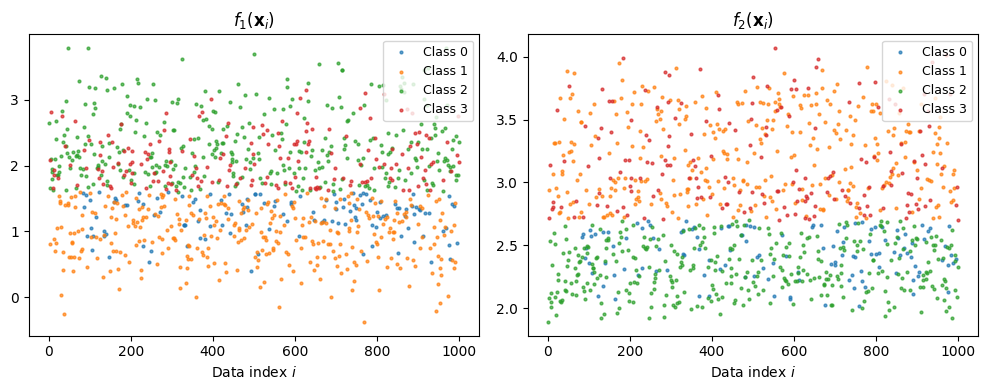


Training set: 713 samples
Testing set: 287 samples

Class one-hot labels: 
tensor([[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])


In [5]:
# For dataset random-number generation

import torch

torch.set_num_threads(1)  # setting PyTorch as single-thread
torch.set_num_interop_threads(1)

SEED = 3
torch.manual_seed(SEED)

import utils

# Generating toy data
# It generates a synthetic 4-feature, 4-class dataset, 
# where each sample’s class is determined by two nonlinear functions of random inputs 
# (using sin, cos, exp, etc.) and thresholds on their outputs.
data_train, data_test = utils.generate_toy_data(feature_dim=4, sample_num=1000, seed=SEED)

print(f"\nClass one-hot labels: \n{data_train.y_onehot}")

- Importing `autograd`

In [6]:
from autograd import Autograd as MyAutograd__, AutogradBackends

MyAutograd__.set_backend(AutogradBackends.C)

#### 2-2 Model definition

In [7]:
import autograd as myautograd__

from autograd import Functional as F


dim = 4
hidden_size = 64
bsz = 16
num_epochs = 2000
lr = 0.05

class MyModel:
    def __init__(self, dim: int, hidden_size: int):
        # initializing parameters
        self.w0 = myautograd__.from_tensor(0.1 * torch.randn(dim, hidden_size))
        self.b0 = myautograd__.from_tensor(0.1 * torch.randn(hidden_size))
        self.w1 = myautograd__.from_tensor(0.1 * torch.randn(hidden_size, hidden_size))
        self.b1 = myautograd__.from_tensor(0.1 * torch.randn(hidden_size))
        self.w2 = myautograd__.from_tensor(0.1 * torch.randn(hidden_size, dim))
        self.w0.requires_grad = True
        self.b0.requires_grad = True
        self.w1.requires_grad = True
        self.b1.requires_grad = True
        self.w2.requires_grad = True
    
    def parameters(self) -> list[myautograd__.Tensor]:
        return [self.w0, self.b0, self.w1, self.b1, self.w2]
    
    @property
    def num_params(self) -> int:
        return sum(p.numel for p in self.parameters())
    
    def layer(self, x: myautograd__.Tensor) -> myautograd__.Tensor:
        h0 = F.mm.forward([x, self.w0])
        h0_ = F.add.forward([h0, self.b0])
        x1 = F.sigmoid.forward([h0_])
        h1 = F.mm.forward([x1, self.w1])
        h1_ = F.add.forward([h1, self.b1])
        x2 = F.relu.forward([h1_])
        out = F.mm.forward([x2, self.w2])
        return out

    def forward(self, x: myautograd__.Tensor) ->  myautograd__.Tensor:
        for _ in range(2):
            x = self.layer(x)
        return x


model = MyModel(dim=dim, hidden_size=hidden_size)

- Computation graph of above model:

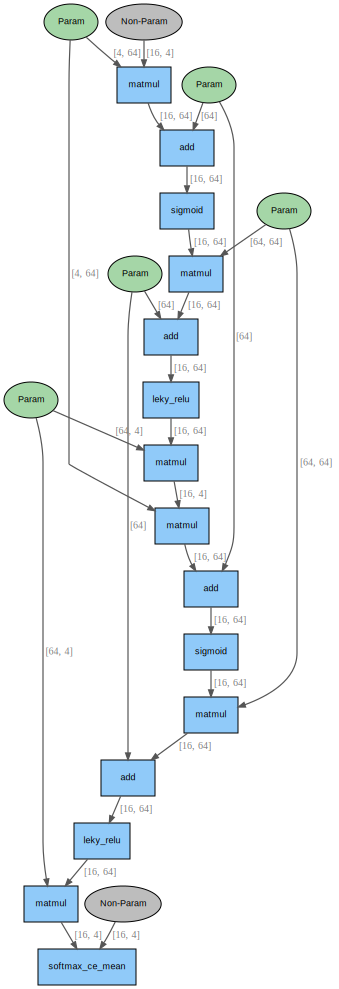

In [8]:
# Computational graph visualizer on
MyAutograd__.set_track_graph(True)

# Prepare sample data for JIT forward
train_loader = utils.DataLoader(data_train, bsz=bsz, backend="c")
data_gen = ((x, y) for x, _, y in train_loader)
x, y = next(data_gen)

# FORWARD PASS for graph tracking
out = model.forward(x)
loss = F.softmax_ce_mean.forward([out, y])

# drawing computation graph
MyAutograd__.draw_computation_graph(loss)

#### 2-3 Training with `autograd`

100%|██████████| 2000/2000 [00:13<00:00, 149.90it/s]

----- Model #params: 4736 -----
[RESULT] | Accuracy: 0.9512
	forward total 3.31 seconds (0.000037sec/it)
	backward total 8.00 seconds (0.000089sec/it)


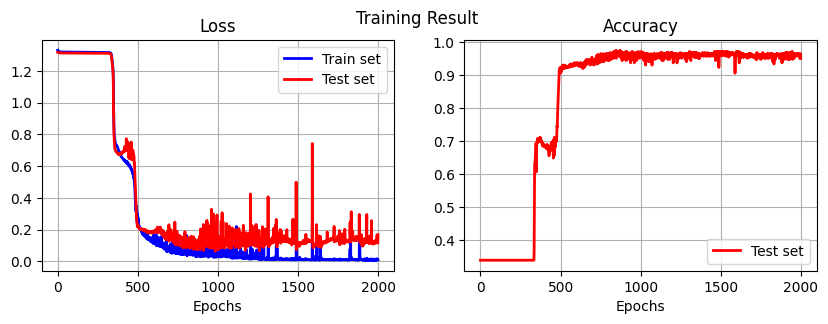

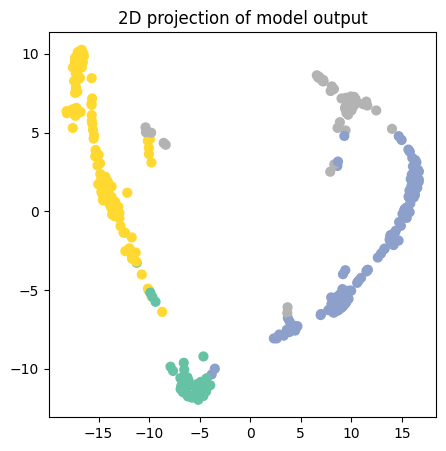

In [9]:
# Computational graph visualizer off for efficient training
MyAutograd__.set_track_graph(False)


from time import perf_counter
from tqdm import tqdm


optimizer = myautograd__.SGDOptimizer(model.parameters(), lr=lr)  # optimizer helper

train_loader = utils.DataLoader(data_train, bsz=bsz, backend="c")
train_loader.shuffle()

train_loss, test_loss, test_acc = [], [], []

forward_time, backward_time = 0.0, 0.0
step = 0
for epoch in tqdm(range(num_epochs)):
    loss_sum = 0
    
    for x_train, y_train, y_train_onehot in train_loader:
        forward_st = perf_counter()
        # >>> FORWARD PASS >>>
        out = model.forward(x_train)
        loss = F.softmax_ce_mean.forward([out, y_train_onehot])
        # <<< FORWARD PASS <<<
        forward_ft = perf_counter()

        backward_st = perf_counter()
        # >>> BACKWARD PASS >>>
        loss.backward()
        optimizer.step()
        # <<< BACKWARD PASS <<<
        backward_ft = perf_counter()
        
        optimizer.zero_grad()

        loss_sum += loss.getelement([0]) * train_loader.bsz
        
        forward_time += (forward_ft - forward_st)
        backward_time += (backward_ft - backward_st)
        step += 1

    train_loss.append(loss_sum / data_train.num_samples)

    test_x = myautograd__.from_tensor(data_test.x)
    test_y_onehot = myautograd__.from_tensor(data_test.y_onehot)

    # EVALUATING
    test_out = model.forward(test_x)
    loss_ = F.softmax_ce_mean.forward([test_out, test_y_onehot]).getelement([0])
    test_loss.append(loss_)

    # computing accuracy
    pred_test = torch.from_numpy(test_out.numpy()).softmax(dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append(test_correct.sum() / data_test.num_samples)

print(
    f"----- Model #params: {model.num_params} -----\n"
    f"[RESULT] | Accuracy: {test_acc[-1]:.4f}\n"
    f"\tforward total {forward_time:.2f} seconds "
    f"({forward_time / step:.6f}sec/it)\n"
    f"\tbackward total {backward_time:.2f} seconds "
    f"({backward_time / step:.6f}sec/it)"
)

utils.visualize_results(
    train_loss,
    test_loss,
    test_acc,
    last_hiddens=test_out.numpy(),
    labels=data_test.y.numpy(),
)

#### 2-4 Versus `PyTorch`

100%|██████████| 2000/2000 [00:16<00:00, 123.89it/s]

----- Model #params: 4736 -----
[RESULT] | Accuracy: 0.9652
forward total 3.82 seconds (0.000043sec/it)
backward total 10.41 seconds (0.000118sec/it)


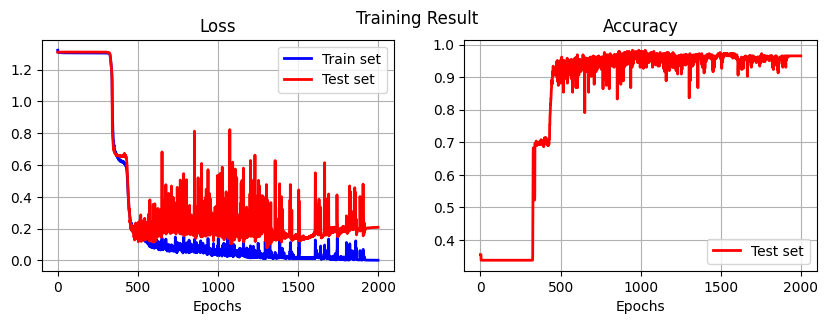

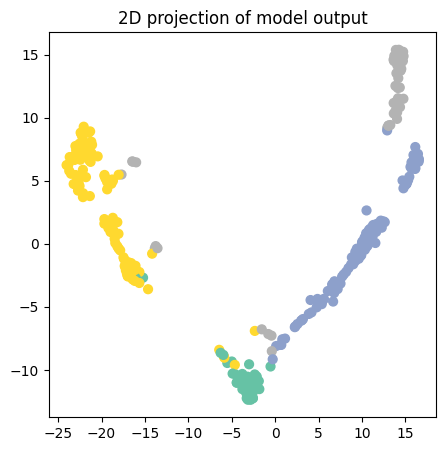

In [11]:
# Defining exactly same PyTorch Model
class FeedForward(torch.nn.Module):
    def __init__(self, dim: int, hidden_size: int):
        super().__init__()
        self.w0 = torch.nn.Parameter(0.1 * torch.randn(dim, hidden_size).float())
        self.b0 = torch.nn.Parameter(0.1 * torch.randn(hidden_size).float())
        self.w1 = torch.nn.Parameter(0.1 * torch.randn(hidden_size, hidden_size).float())
        self.b1 = torch.nn.Parameter(0.1 * torch.randn(hidden_size).float())
        self.w2 = torch.nn.Parameter(0.1 * torch.randn(hidden_size, dim))

    @property
    def num_params(self) -> int:
        return sum(p.numel() for p in self.parameters())

    def layer(self, x: torch.Tensor) -> torch.Tensor:
        x = x.mm(self.w0) + self.b0
        x = x.sigmoid()
        x = x.mm(self.w1) + self.b1
        x = x.relu()
        x = x.mm(self.w2)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(2):
            x = self.layer(x)
        return x


model = FeedForward(dim=dim, hidden_size=hidden_size)
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)
softmax_ce_mean = torch.nn.CrossEntropyLoss(reduction="mean")

train_loader = utils.DataLoader(data_train, bsz=bsz, backend="torch")
train_loader.shuffle()

train_loss, test_loss, test_acc = [], [], []

forward_time, backward_time = 0.0, 0.0
for epoch in tqdm(range(num_epochs)):
    model.train()
    loss_sum = 0

    for step, (x_train, y_train, y_train_onehot) in enumerate(train_loader):
        forward_st = perf_counter()
        out = model.forward(x_train)
        loss = softmax_ce_mean.forward(out, y_train_onehot)
        forward_ft = perf_counter()

        ##### BACKWARD PASS #####
        backward_st = perf_counter()
        loss.backward()
        optimizer.step()
        backward_ft = perf_counter()

        optimizer.zero_grad()

        loss_sum += loss.item() * len(x_train)

        forward_time += (forward_ft - forward_st)
        backward_time += (backward_ft - backward_st)

    train_loss.append(loss_sum / data_train.num_samples)

    # EVALUATING
    model.eval()
    test_out = model.forward(data_test.x)
    test_loss.append(softmax_ce_mean.forward(test_out, data_test.y_onehot).item())

    # computing accuracy
    pred_test = torch.softmax(test_out, dim=-1).argmax(dim=-1)
    test_correct = pred_test == data_test.y
    test_acc.append((test_correct.sum() / data_test.num_samples).item())

print(
    f"----- Model #params: {model.num_params} -----\n"
    f"[RESULT] | Accuracy: {test_acc[-1]:.4f}\n"
    f"forward total {forward_time:.2f} seconds "
    f"({forward_time / (step * num_epochs):.6f}sec/it)\n"
    f"backward total {backward_time:.2f} seconds "
    f"({backward_time / (step * num_epochs):.6f}sec/it)"
)

utils.visualize_results(
    train_loss,
    test_loss,
    test_acc,
    last_hiddens=test_out.detach().numpy(),
    labels=data_test.y.numpy()
)